In [15]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import oslo_lib

ox.settings.use_cache=True
ox.settings.log_console=True

def get_boundaries(array):
    return min(array), max(array)

def get_spread(boundaries):
    return max(boundaries) - min(boundaries)

def get_center(spread):
    return np.mean(spread)

def get_window(center, spread, buffer):
    buffer = buffer*spread/2
    return (center - spread/2 - buffer), (center + spread/2 + buffer)

def get_windows(latitudes, longitudes, buffer):

    longitude_spread = get_spread(longitudes)
    longitude_center = get_center(longitudes)
    longitude_window = get_window(longitude_center, longitude_spread, buffer)

    latitude_spread = get_spread(latitudes)
    latitude_center = get_center(latitudes)
    latitude_window = get_window(latitude_center, latitude_spread, buffer)
    
    return latitude_window, longitude_window

def window_filter(series, window):
    f1 = series >= window[0]
    f2 = series <= window[1]    
    return (f1) & (f2)

In [16]:
city, country = 'Milan', 'Italy'
bike_sharing_stations = pd.read_pickle(f'{city}/stations.pkl')
bike_sharing_stations = oslo_lib.get_geostations(bike_sharing_stations).to_crs('epsg:4326')

bike_sharing_stations.longitude = bike_sharing_stations.geometry.x
bike_sharing_stations.latitude = bike_sharing_stations.geometry.y

longitude_window, latitude_window = get_windows(get_boundaries(bike_sharing_stations.longitude), 
                                                get_boundaries(bike_sharing_stations.latitude), 
                                                buffer=.1)

city_bbox = longitude_window[0], latitude_window[0], longitude_window[1], latitude_window[1]

def geo_filter(df, latitude_window=latitude_window, longitude_window=longitude_window):
    lat_filter = window_filter(df.latitude, latitude_window)
    lon_filter = window_filter(df.longitude, longitude_window)
    return (lat_filter) & (lon_filter)

In [17]:
def factorial(x):
    if x==1:
        return 1
    else:
        return x * factorial(x-1)

In [18]:
# Get street network 
G_bikes = ox.graph_from_bbox(city_bbox, network_type='bike')
G_bikes_projected = ox.project_graph(G_bikes)
city_crs = G_bikes_projected.graph['crs']

nodes, edges = ox.graph_to_gdfs(G_bikes_projected)
cycleways = edges[edges.highway.apply(lambda x : 'cycleway' in x)]
cycleway_graph = ox.graph_from_gdfs(nodes, cycleways)

In [19]:
stations_coordinates = bike_sharing_stations.to_crs(city_crs).geometry.apply(lambda x : list(np.array(x.xy).squeeze())).to_list()
stations_coordinates = np.array(stations_coordinates).T

In [20]:
bike_sharing_stations["node"] = ox.nearest_nodes(G_bikes_projected, *stations_coordinates)

In [21]:
def get_path(orig_station, dest_station):
    # https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed-time.ipynb
    path = ox.shortest_path(G_bikes_projected, orig_station, dest_station, weight="length")
    path = [*zip(path, path[1:])]
    return edges.reset_index(level=2, drop=True).loc[path]

(np.float64(506567.7581226516),
 np.float64(519292.00404951436),
 np.float64(5030773.370625432),
 np.float64(5042478.308631686))

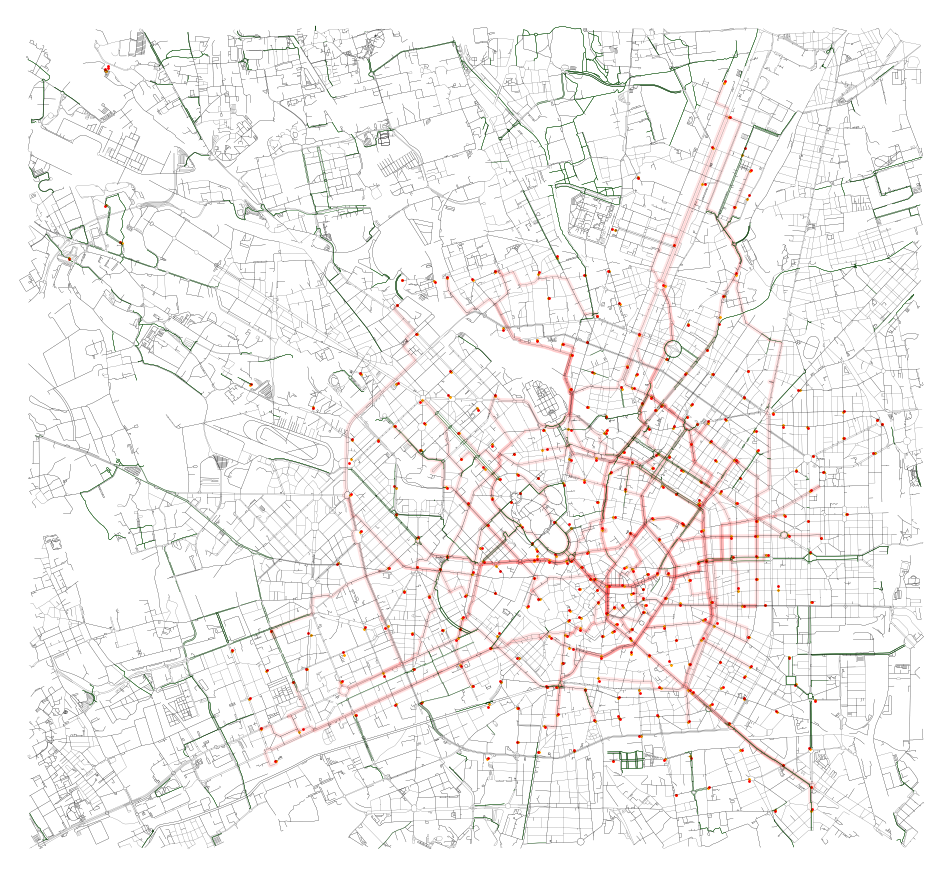

In [22]:
ax = edges.plot(markersize=.1, figsize=(12,12), lw=.1, color='k')

station_nodes = bike_sharing_stations.node.to_list()
nodes.loc[station_nodes].plot(marker='x', ax=ax, color='orange', markersize=1.5)
bike_sharing_stations.to_crs(city_crs).plot(ax=ax, c='r', markersize=1)
ox.plot_graph(cycleway_graph, node_size=0, edge_color='green', ax=ax, show=False, edge_linewidth=.2)

for i in range(50):
    path = get_path(*bike_sharing_stations.node.sample(2).to_list())
    path.plot(ax=ax, alpha=.1, color='r', lw=3, zorder=-1)

ax.axis("off")

# Trial: Can we plot the road usage at 6am vs 2pm?

In [23]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [24]:
trips = pd.read_pickle(f'{city}/processed_trips.pkl')

Text(0, 0.5, 'proportion of total trips')

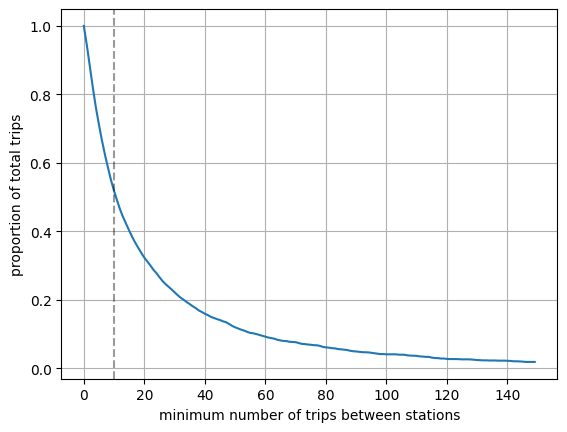

In [25]:
h = 14

n_trips = trips.query(f"hour=={h}")[["start_station_id", "end_station_id"]].value_counts().rename("n_trips").to_frame()
ax = pd.DataFrame([(i, (n_trips[n_trips.n_trips>i].sum() / n_trips.n_trips.sum()).iloc[0]) for i in range(150)]).set_index(0)[1].plot()
ax.grid()
ax.axvline(10, ls='--', c='k', alpha=.4)
ax.set_xlabel("minimum number of trips between stations")
ax.set_ylabel("proportion of total trips")

In [26]:
def get_n_trips(hour, year, min_trips=1):
    n_trips = trips.query(f"hour=={hour} & year=={year}")[["start_station_id", "end_station_id"]].value_counts().rename("n_trips").to_frame()
    n_trips = n_trips.query(f"n_trips>={min_trips}")
    n_trips = n_trips.sort_values(by="n_trips", ascending=False)
    n_trips["hour"] = hour
    return n_trips

def get_paths(bike_sharing_stations=bike_sharing_stations, head=500, city_crs=city_crs):
    paths = pd.DataFrame()
    ids = bike_sharing_stations.index.to_list()
    orig_dest_values = pd.MultiIndex.from_product([ids, ids])
    if head:
        orig_dest_values = orig_dest_values[:head]
    for ix in orig_dest_values:
        path = get_path(*bike_sharing_stations.loc[ix, ["node"]].to_numpy().squeeze())
        path[["start_station_id", "end_station_id"]] = ix
        paths = pd.concat([paths, path[["start_station_id", "end_station_id", "geometry"]]])
    return paths

def enrich_path(n_trips):
    n_trips = n_trips.groupby("geometry").n_trips.sum().reset_index()
    n_trips["alpha"] = n_trips.n_trips / n_trips.n_trips.max()    
    return n_trips

def get_trip_counter(hour, trips=trips):
    departures = trips.query(f'hour=={hour}').start_station_id.value_counts().rename("departures")
    arrivals = trips.query(f'hour=={hour}').end_station_id.value_counts().rename("arrivals")
    return gpd.GeoDataFrame(pd.concat([departures, arrivals], axis=1).join(bike_sharing_stations.geometry))

def plot_paths(hour, year, all_paths=all_paths, trips=trips, edges=edges, cycleway_graph=cycleway_graph):
    paths = all_paths.query(f"hour=={hour} & year=={year}")
    trip_counter = get_trip_counter(hour)
    trip_counter['total'] = trip_counter.departures + trip_counter.arrivals
    ax = edges.plot(markersize=.1, figsize=(12,12), lw=.1, color='k')
    ox.plot_graph(cycleway_graph, node_size=0, edge_color='green', ax=ax, show=False, edge_linewidth=.2)
    paths.plot(cmap="Oranges", ax=ax, alpha=paths["alpha"], zorder=-1, lw=2)
    trip_counter.to_crs(city_crs).plot(
#        edgecolor='k',
        alpha=.6,
        cmap='Reds',
        column='total',
        markersize=trip_counter.total/200,
        ax=ax
    )
    ax.axis("off")
    ax.set_title(paths.hour.iloc[0])


def plot_paths_comparison(hour, years, all_paths=all_paths, trips=trips, edges=edges, cycleway_graph=cycleway_graph):
    fig, axes = plt.subplots(2, 2, figsize = (16, 12))
    axes = axes.flatten()
    for year, ax in zip(years, axes):
        paths = all_paths.query(f"hour=={hour} & year=={year}")
        trip_counter = get_trip_counter(hour, trips.query(f'year=={year}'))
        trip_counter['total'] = trip_counter.departures + trip_counter.arrivals
        edges.plot(markersize=.1, lw=.1, color='k', ax=ax)
        ox.plot_graph(cycleway_graph, node_size=0, edge_color='green', ax=ax, show=False, edge_linewidth=.2)
        paths.plot(cmap="Oranges", ax=ax, alpha=paths["alpha"], zorder=-1, lw=2)
        trip_counter.to_crs(city_crs).plot(
    #        edgecolor='k',
            alpha=.6,
            cmap='Reds',
            column='total',
            markersize=trip_counter.total/200,
            ax=ax
        )
        ax.axis("off")
        ax.set_title(f"{hour}h; {year}")
    plt.tight_layout()

NameError: name 'all_paths' is not defined

In [14]:
inter_station_paths = get_paths(head=None)

KeyboardInterrupt: 

In [ ]:
inter_station_paths.to_file(f'{city}/inter_station_paths.shp')

/tmp/ipykernel_4797/3705954039.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  inter_station_paths.to_file('Oslo/inter_station_paths.shp')


In [ ]:
all_paths = pd.DataFrame()
step = 1
hours = [*range(0, 24, step)]

for year in (2019, 2020, 2021, 2022, 2023):
    for hour in hours:
        n_trips = get_n_trips(hour, year)
        n_trips = inter_station_paths.join(n_trips, on=['start_station_id', 'end_station_id'])
        if len(n_trips) == 0:
            continue
        n_trips = enrich_path(n_trips)
        n_trips["hour"] = hour
        n_trips["year"] = year
        all_paths = pd.concat([all_paths, n_trips])

all_paths = gpd.GeoDataFrame(all_paths, crs=city_crs)
all_paths['alpha'] = all_paths['alpha'].fillna(0).apply(lambda x : max(x, .05))

In [94]:
plot = lambda h : plot_paths(h, year=2019)

m = min(hours)
M = max(hours)
slider = widgets.IntSlider(min=m, max=M, step=step, value=0)
play = widgets.Play(
    value=0,
    min=m,
    max=M,
    step=step,
    interval=1500,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (slider, 'value'))
interact(plot, h=play)

interactive(children=(Play(value=0, description='Press play', interval=1500, max=23), Output()), _dom_classes=…

<function __main__.<lambda>(h)>

In [95]:
plot = lambda h : plot_paths_comparison(h, years=[2019, 2020, 2021, 2022])
interact(plot, h=slider)

interactive(children=(IntSlider(value=0, description='h', max=23), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(h)>